In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
# Doesn't seem to actually save, do I need to load the account?
QiskitRuntimeService.save_account(channel="ibm_quantum", token="0c83235dfdb38f43eb41f2e7c2962cc95af284fe46d1434151cd439eab3f5ce9d53a6805cede3054a985a10e43874de7f4dff0a9eb3b7388150d290c0ebe9bda", set_as_default=True)
#qiskit_ibm_provider.IBMProvider.load(account)

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

# Basic Quantum Information

## Multiple Systems

In [1]:
from qiskit.quantum_info import Statevector, Operator
from numpy import sqrt

In [2]:
zero, one = Statevector.from_label("0"), Statevector.from_label("1")

In [3]:
zero.tensor(one).draw('latex')

<IPython.core.display.Latex object>

In [11]:
plus = Statevector.from_label('+')
i_state = Statevector([1, 1j]/sqrt(2))
psi = plus.tensor(i_state)
psi.draw('latex')

<IPython.core.display.Latex object>

In [10]:
X = Operator([[0, 1], [1, 0]])
I = Operator([[1,0], [0,1]])
X.tensor(I).draw('latex')

<IPython.core.display.Latex object>

In [14]:
# qiskit prefers this "evolve" operator instead of multiplying matrices
psi.evolve(I ^ X).draw('latex')

<IPython.core.display.Latex object>

In [15]:
W = Statevector([0, 1, 1, 0, 1, 0, 0, 0] / sqrt(3))
W.draw("latex")

<IPython.core.display.Latex object>

In [19]:
results, new_sv = W.measure([0]) # returns result and collapse measurement
# always recall that rightmost qubit is 0

In [20]:
new_sv.draw('latex')

<IPython.core.display.Latex object>

## Entaglement in Action

### Teleportation

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UGate
from numpy import pi, random
#from qiskit.result import mariginal_distribution

In [11]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

teleportation = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit
teleportation.h(ebit0)
teleportation.cx(ebit0,ebit1)
teleportation.barrier()

# The Bell measurement
teleportation.cx(0, 1)
teleportation.h(0)
teleportation.measure(qubit, b)
teleportation.measure(ebit0, a)

with teleportation.if_test((a, 1)):
    teleportation.x(ebit1)
with teleportation.if_test((b, 1)):
    teleportation.z(ebit1)

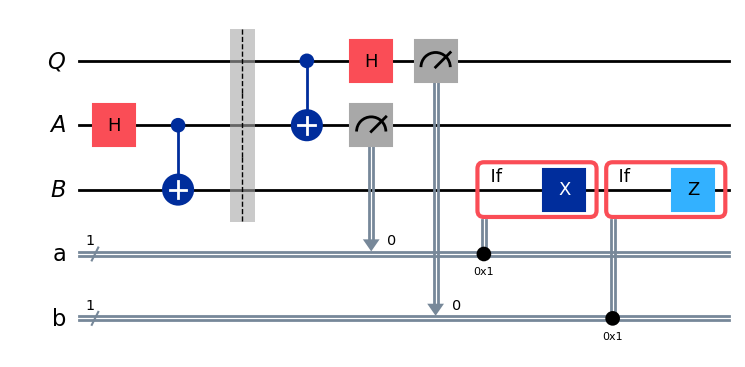

In [12]:
teleportation.draw('mpl')

Ok so to see if this worked, we can apply a random get to the teleported state (essentially getting a random state). Then apply the inverse on `ebit0` and we should get the |0> vector

In [13]:
random_gate = UGate(
    theta=random.random() * 2 * pi, 
    phi=random.random() * 2 * pi, 
    lam=random.random() * 2 * pi
)

In [15]:
random_gate.to_matrix()

array([[ 0.3235958 +0.j        , -0.84075845-0.43406335j],
       [-0.26851536+0.90729557j, -0.22394368+0.23358825j]])

In [25]:
# These registers exist outside of their use in the protocol
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# initialize the random state
test.append(random_gate, qubit)

# pipe into teleportation - compose seems to return a circuit rather than modify
test = test.compose(teleportation)

# add inverse U onto ebit1
test.append(random_gate.inverse(), ebit1)

# add
result = ClassicalRegister(1, "result")
test.add_register(result)
test.measure(ebit1, result)

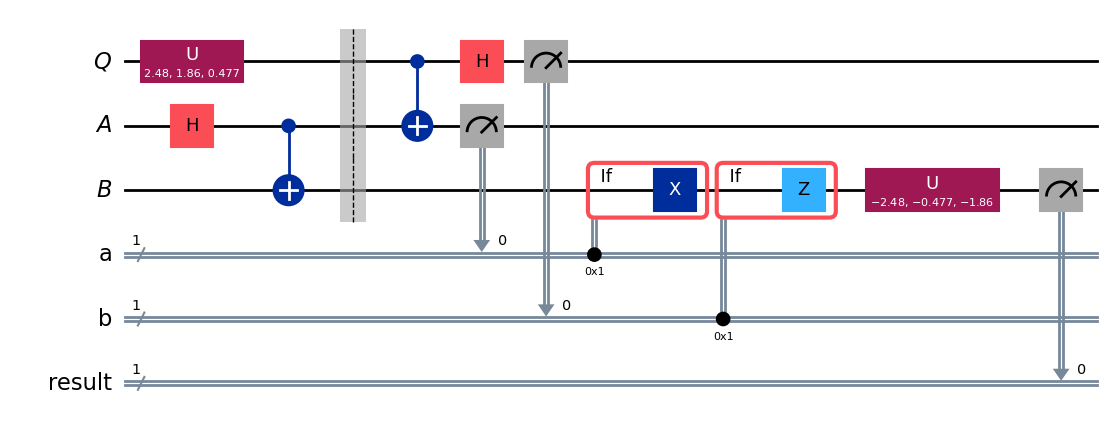

In [26]:
test.draw('mpl')

In [28]:
result = AerSimulator().run(test).result()

In [30]:
result.get_counts()

{'0 0 1': 267, '0 0 0': 251, '0 1 0': 260, '0 1 1': 246}

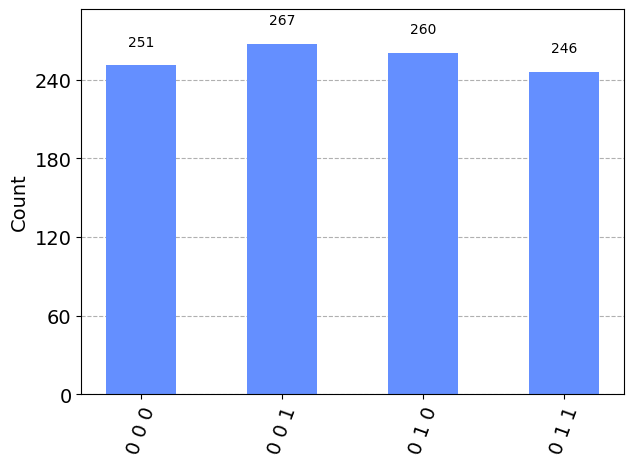

In [35]:
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts())

There is a way to focus only on the marginal distribution of `ebit2` (which is always 0 here), but I wasn't able to import the function for some reason

### Superdense Coding

The idea here is very simple. Alice has 2 classical bits she wants to communicate to Bob, but (somehow) finds it easier to send over a qubit rather than the 2 classical bits. Alice and Bob share an EPR pair and Alice alters the joint state to make it one of the 4 Bell states. She then sends her half of the pair to Bob who then does a measurement (a Bell measurement) and by determining which of the 4 Bell states the pair is in, they successfully communicated 2 bits of info.

Note that a "Bell Measurement" is equivalent to performing a CNOT, then Hadamar, then measuring in the computational basis.

In [38]:
c = "1"
d = "0"

# Prepare Bell State
superdense = QuantumCircuit(2)
superdense.h(0)
superdense.cx(0,1)


if d == "1":
    superdense.z(0)
if c == "1":
    superdense.x(0)


superdense.barrier()

superdense.measure_all() # don't have to instatiate a classical register if you use measure_all

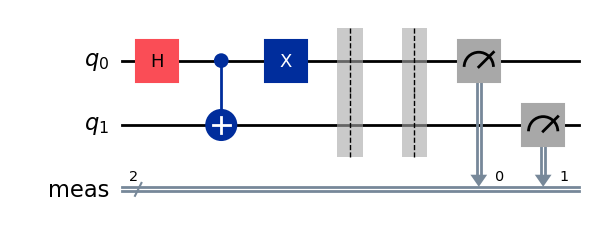

In [39]:
superdense.draw('mpl')

|00> + |11>

Z then X yield (on qubit 0 - we'll use qiskit notation here)

|01> - |10>

But X then Z yield

 -|01> + |10>

So it's just off by an overall phase. So why does commuting relationships matter again?

## CHSH Game

# Variational Quantum Eigensolver

Basic requirements for solution
- Hamiltonian and ansatz (ansatz is guess circuit)
- Qiskit Runtime estimator
- Classical optimizer

## Setup

In [1]:
# General
import warnings
warnings.filterwarnings("ignore")
import numpy as np

# Pre-defined ansatz ckts
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Classical optimization
from scipy.optimize import minimize

# Plotting
import matplotlib.pyplot as plt

In [2]:
# Should figure out a way to get the service without feeding in the token everytime

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# Load saved credentials
service = QiskitRuntimeService(channel="ibm_quantum", token="0c83235dfdb38f43eb41f2e7c2962cc95af284fe46d1434151cd439eab3f5ce9d53a6805cede3054a985a10e43874de7f4dff0a9eb3b7388150d290c0ebe9bda")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Map classical inputs to quantum problem

In [3]:
# The hamiltonian is domain specific but this example problem 
# is apaprently derived from quantum chemistry

# Just a linear combination of Paulis to make the Hamiltonian
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

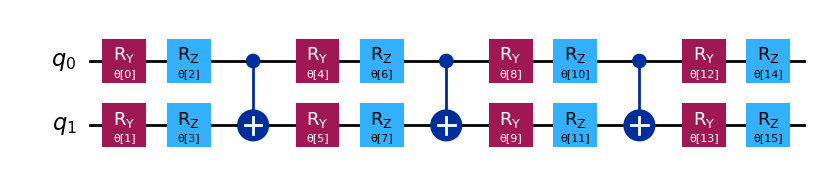

In [4]:
# Ok so it made a parameterized circuit
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl")

In [5]:
num_params = ansatz.num_parameters
num_params

16

## Optimize problem for quantum execution

What exactly is meant by observable?

The Qiskit runtime only accepts circuits (ansatz) and observables (Hamiltonian) that conform to some specifications (this is just some execution optimization details). The specifications are known as (ISA) instuction set architecture. These need to be optimized for a given backend.

In [6]:
# This makes our circuit follow ISA formatting
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3) # higher optimization means smarter architecture and fewer gates

ansatz_isa = pm.run(ansatz)

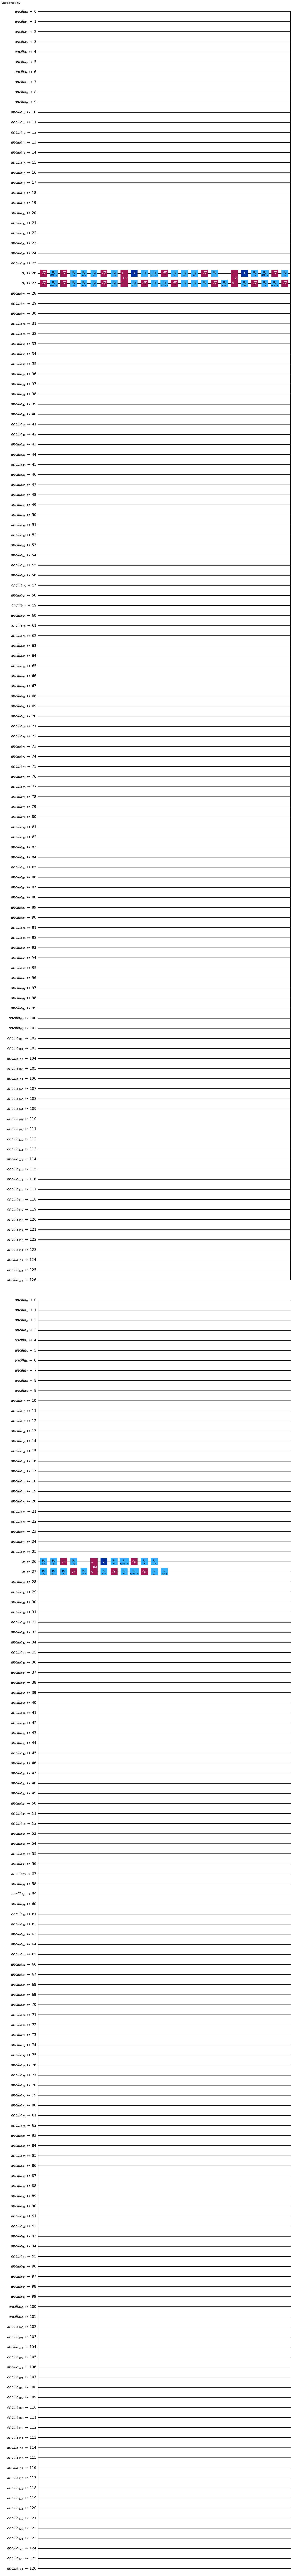

In [7]:
#ansatz_isa.draw('mpl') # interestingly shows a huge number of ancilla qubits
#ansatz_isa.decompose().draw('mpl') also include FTQC (3 repitition for example!)

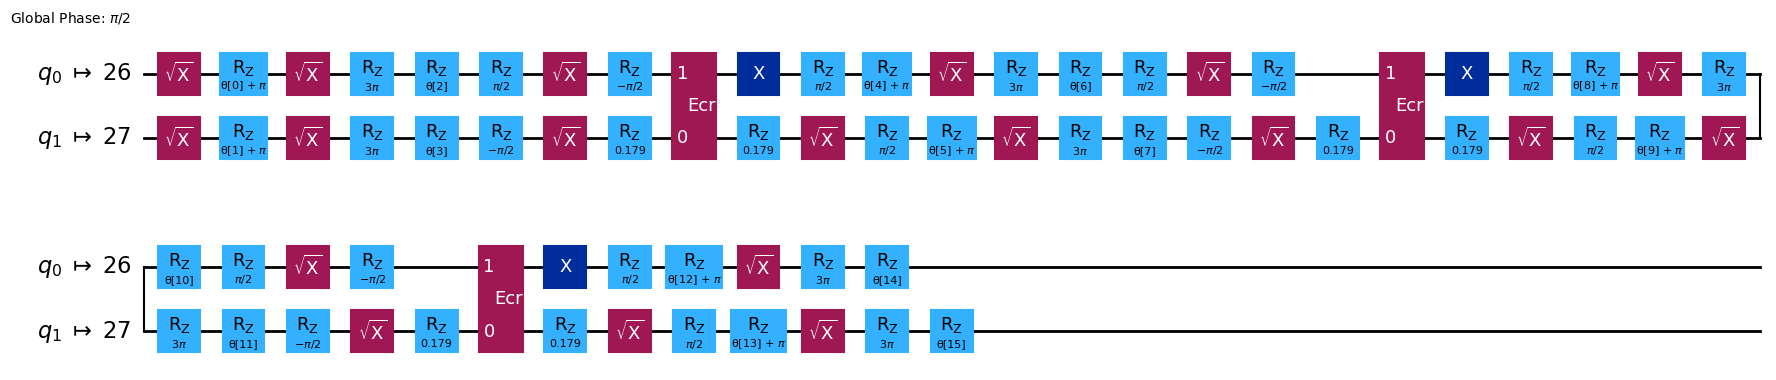

In [9]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [10]:
# Hamiltonian als needs to be transformed

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [12]:
# adds a ton of identity operators to all the ancilla qubits lol
# hamiltonian_isa

## Execute using Qiskit Primitives

VQE is trying to find ground state solution to Hamiltonian. Ground energy is bounded above by expectation energy, so minimizing the expectation energy of the Hamiltonian is a way of finding the ground state solution. The `Estimator` primitive lets you take the expectation value of a Hamiltonian easily.

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
        # whats the structure of result[0].data? 
    """
    pub = (ansatz, [hamiltonian], [params]) # Primitive Unified Bloc
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    return energy

"Callback" functions are a standard programming tool that let you get intermediate information during iterative calculation. This could help if a program needs to be restarted for example.

In [14]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

In [15]:
callback_dict = {
    "prev_vector": None,
    "iters": 0, 
    "cost_history": []
}

In [16]:
# 16 random parameter values for our ansatz
x0 = 2 * np.pi * np.random.random(num_params)

In [18]:
x0

array([2.61827219, 1.323622  , 0.57553633, 1.48612365, 3.14961211,
       2.76351221, 5.67331607, 2.88328106, 0.52698068, 3.09248294,
       0.69908282, 4.68420286, 4.97428327, 4.71834732, 1.02274148,
       6.10787839])

`Session` executes many circuits in a single block.

In [19]:
backend

<IBMBackend('ibm_kyoto')>

In [ ]:
# This is literally in the queue, so will probably appear in my account later
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10_000

    callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)

    res = minimize(cost_func,
                   x0, 
                   args=(ansatz_isa, hamiltonian_isa, estimator), 
                   method="cobyla",
                   callback=callback,
                  )

base_runtime_job._start_websocket_client:WARNING:2024-04-02 19:56:51,021: An error occurred while streaming results from the server for job cr6899xtxj10008a3q00:
Traceback (most recent call last):
  File "/Users/jaj97/opt/anaconda3/envs/qiskit/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Users/jaj97/opt/anaconda3/envs/qiskit/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Users/jaj97/opt/anaconda3/envs/qiskit/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/Users/jaj97/opt/anaconda3/en

In [21]:
res # ok well ideally this would work but the job got stuck in the queue on the quantum computer

NameError: name 'res' is not defined

The result returns parameters to optimize the ansatz circuit. You can think of the ansatz as architecture specifying the degrees of freedom. I think if you insert the 0 state into the circuit you'd get the desired ground state

These can tell you that the run competed successfully without interuption with the following lines

In [ ]:
all(callback_dict["prev_vector"] == res.x)

In [ ]:
callback_dict["iters"] == res.nfev

This tells you how well the cost function improved over iterations

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# Fundamentals of Quantum Query Algorithms

Review Bernstein_vazzarani with Deutsch and compare

## Quantum query algorithms

There is a hidden function that you are trying characterize. Sometimes there are "promise functions" which put constraints on the function (or limit the domain). I expect that the complexity of these problems are different.

Deutsch Function

In [1]:
from qiskit import QuantumCircuit

# This is just the query gate

def deutsch_function(case: int):
    """
    Generate a valid Deutsch function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

In [2]:
display(deutsch_function(3).draw())

q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘

In [5]:
# Now we'll actually use this query gate to construct our algorithm

def compile_circuit(function: QuantumCircuit):

    n = function.num_qubits - 1
    qc = QuantumCircuit(n+1, n)

    # Last qubit set to minus, rest set to plus
    qc.x(n) 
    qc.h(range(n+1))
    qc.barrier()

    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

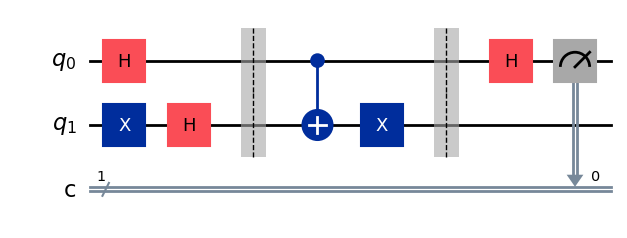

In [7]:
compile_circuit(deutsch_function(3)).draw('mpl')

Cruicial to this problem is that fact that |-> is an eigenstate of X, and the XOR between single-bit strings is similar to the conditional NOT operation on a string.

Phase kick back is where an action happens on qubit 0, but seemingly changes the state such that only qubit 1 is affected (because the action was dependent on the value of qubit 1, so qubit 0 can get factored out).

Let's simulate

In [14]:
from qiskit_aer import AerSimulator

def deutsch_algorithm(function: QuantumCircuit):
    # determine is fxn is balanced
    
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurement = result.get_memory() 
    # apparently returns a list of the results from each shot
    # not a dictionary

    if measurement[0] == '0':
        return 'balanced'
    else:
        return 'constant'

In [15]:
f = deutsch_function(2)
deutsch_algorithm(f)

'constant'

Deutsch-Josza is a natural extension for function that take in strings of length n and output 1 or 0.

The overall is a rotate-compute-rotate problem where you query the uniform superposition (along with an ancilla |-> ket that gets XOR'd with the output of the query). Then you measure the uniform superposition bits. Interestingly the ancilla bit is only really there to perform the phase kickback prior to the measurement.

If the measurement is all 0's then the function in constant, else it is balanced. You can prove this to yourself by assuming f(x) is either balanced or constant and seeing how likely you would be get get the all 0 measurement (either 100% or 0% likely).

In [19]:
# This is a balance vs constant problem, so as before we must give it a function that fits the promise
from qiskit import QuantumCircuit
import numpy as np

def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """

    qc = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # next, choose half the possible input states
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits) # general multi-controlled not gate
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

In [20]:
for qubit, bit in enumerate(reversed('01101100000000')):
    print(qubit, bit)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 1
9 1
10 0
11 1
12 1
13 0


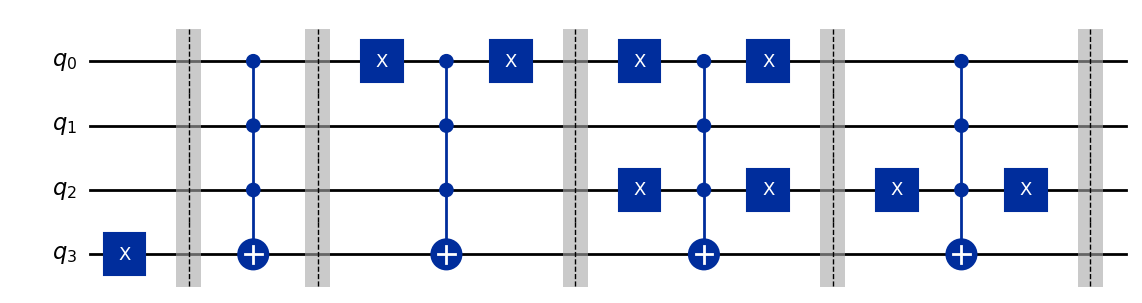

In [21]:
dj_function(3).draw('mpl')

In [62]:
def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    ckt = QuantumCircuit(n+1, n)

    ckt.x(n)
    ckt.h(range(n+1))
    ckt.barrier()
    
    ckt.compose(function, inplace=True)
    ckt.barrier()

    ckt.h(range(n))
    ckt.measure(range(n), range(n))

    return ckt

In [63]:
# occasionally gives the boring constant circuit
func = dj_function(3)
ckt = compile_circuit(func)

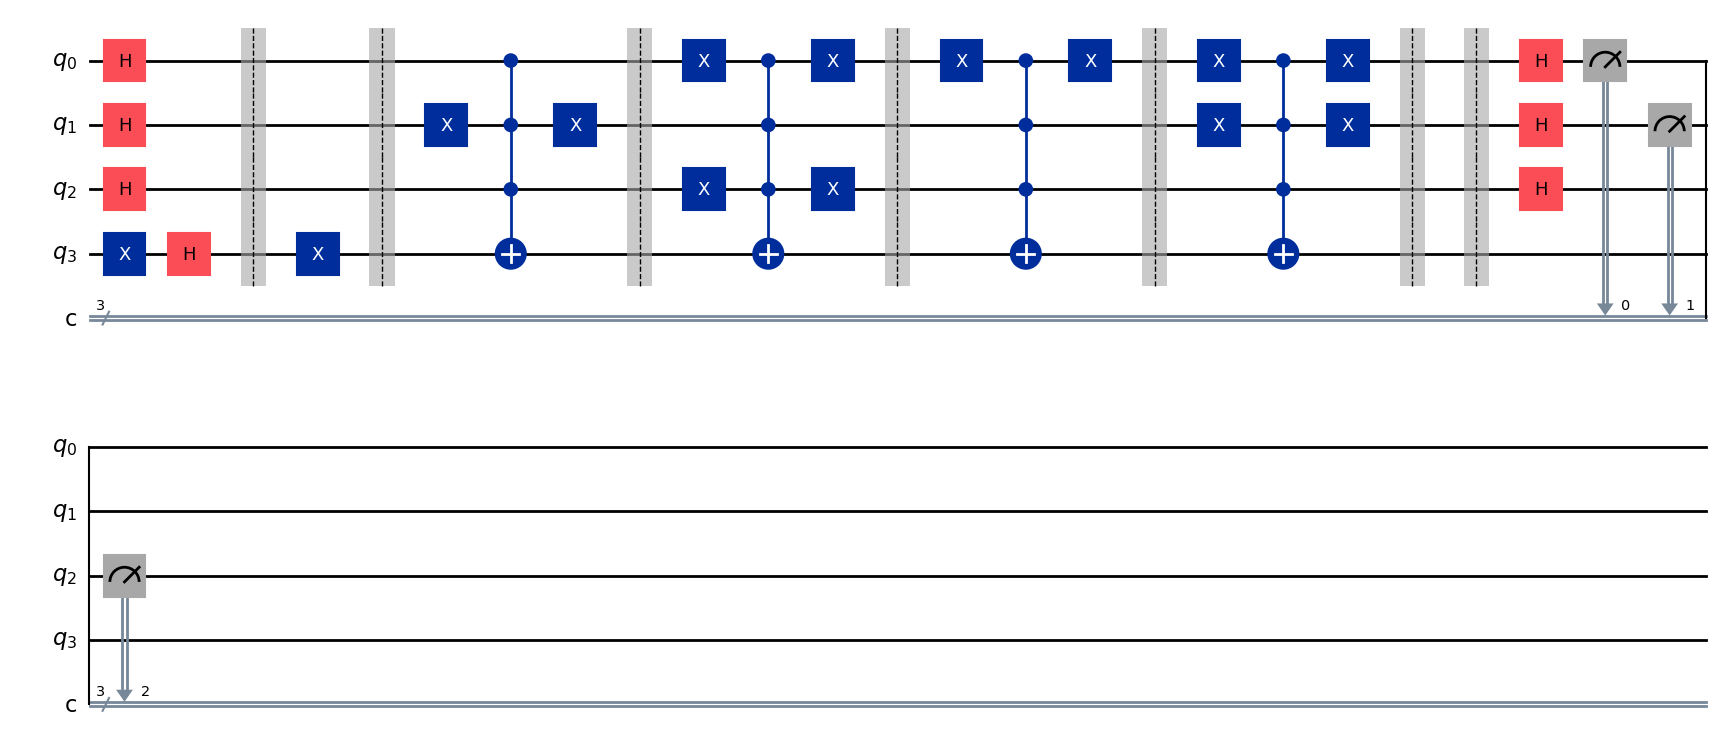

In [64]:
ckt.draw('mpl')

In [69]:
from qiskit_aer import AerSimulator
def dj_algorithm(function: QuantumCircuit):
    simulator = AerSimulator()
    ckt = compile_circuit(function)
    results = simulator.run(ckt, shots=1, memory=True).result()
    answer = results.get_memory()[0]
    return answer

In [67]:
func = dj_function(3)
func.draw()

░ ┌───┐     ┌───┐ ░                 ░                 ░       ░ 
q_0: ──────░─┤ X ├──■──┤ X ├─░────────■────────░────────■────────░───■───░─
           ░ └───┘  │  └───┘ ░        │        ░ ┌───┐  │  ┌───┐ ░   │   ░ 
q_1: ──────░────────■────────░────────■────────░─┤ X ├──■──┤ X ├─░───■───░─
           ░        │        ░ ┌───┐  │  ┌───┐ ░ └───┘  │  └───┘ ░   │   ░ 
q_2: ──────░────────■────────░─┤ X ├──■──┤ X ├─░────────■────────░───■───░─
     ┌───┐ ░      ┌─┴─┐      ░ └───┘┌─┴─┐└───┘ ░      ┌─┴─┐      ░ ┌─┴─┐ ░ 
q_3: ┤ X ├─░──────┤ X ├──────░──────┤ X ├──────░──────┤ X ├──────░─┤ X ├─░─
     └───┘ ░      └───┘      ░      └───┘      ░      └───┘      ░ └───┘ ░

In [75]:
dj_algorithm(func)

'100'